# Sentiment Analysis 2 - PyTorch

## 0. Setup

In [24]:
# General packages
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random

# NLP packages
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling packages
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from src.text_classifiers import RNNClassifier, initialize_weights
from src.tripadvisor_dataset import SentimentDataset, collate
from src.utils import calc_distr


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [25]:
params={
    'SEED': 123,            # seed for random processes                 
    'max_features': 10000,  # vocabulary size
    'embedding_dim': 128,   # size of an embedding vector 
    'hidden_size': 256,     # number of features in the hidden state of the rnn layer
    'rnn_type': 'gru',      # use 'rnn', 'lstm' or 'gru'
    'bidirectional': True, # If True, use bidirectional rnn 
    'n_layers': 5,          # number of layers in the stacked rnn 
    'dropout': 0.4,         # if non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer
    'output_size': 3,       # number of classes
    'gclip': 40,            # To tackle the exploding gradient problem, set gclip and use clip_grad_norm_(X, gclip)
    'batch_size': 16,       # Batch size for stochastic gradient descent
    'lr': 5e-4,           # Learning rate for the Adam optimizer
    'lr_decay': 0.95,       # Learning rate decay parameter for exponential lr scheduling
    'epochs': 25,           # Number of epochs to train the model
    'print_every': None,    # Frequency of printing the loss in an epoch
    'patience': 4,          # Patience value used for early stopping if the performance does not increase.
    'weighted_loss': True   # Use a weighted Cross Entropy Loss function to balance classes
}

## 1. Dataset
### Load Data

In [26]:
data_root = os.path.join(os.path.abspath(os.getcwd()), "data", "tripadvisor_hotel_reviews_preproc.csv")
data = pd.read_csv(data_root)
data.head()

,Review,Rating,Review_preprocessed,Sentiment_rating
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...,1
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,2
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,2


### Create Vocabulary

Build a vocabulary that only consider the top `max_features` ordered by term frequency across the corpus.

In [27]:

tfidfconverter = TfidfVectorizer(use_idf=True, max_features=params['max_features'], min_df=0, max_df=1.0)
tfidfconverter.fit_transform(data['Review_preprocessed'])
pre_vocab = tfidfconverter.vocabulary_

In [28]:
print('Vocabulary size:', len(pre_vocab), '\n\n  Sample words\n{}'.format('-' * 20))
sample_words = random.sample(list(pre_vocab.keys()), 10)
for word in sample_words:
    print(' {}'.format(word))

Vocabulary size: 10000 

  Sample words
--------------------
 softer
 internal
 recomendation
 used
 gross
 hard
 ideally
 lampshade
 minifridge
 oliver


In addition to the words that appear in our data, we need to have two special words:

- `<eos>` End of sequence symbol used for padding
- `<unk>` Words unknown in our vocabulary

In [29]:
vocab = {'<eos>': 0, '<unk>': 1}
for key in pre_vocab.keys():
    vocab[key] = len(vocab)
print('Vocabulary size:', len(vocab))
# for i in range(len(vocab)-50, len(vocab)):
#     print(list(vocab.keys())[list(vocab.values()).index(i)])

Vocabulary size: 10002


### Create Dataset

Steps:
* Tokenize data
* Create index-label pairs based on vocabulary
* Divide into train, validation and test sets
* Wrapping to PyTorch dataset


In [30]:
tokenized_data = []
for i in range(len(data)):
    tokenized_data.append((nltk.word_tokenize(data['Review_preprocessed'][i]), data['Sentiment_rating'][i]))
print(tokenized_data[-1])    

(['people', 'talking', 'ca', 'believe', 'excellent', 'rating', 'hotel', 'yes', 'patricia', 'extremely', 'helpful', 'fluent', 'language', 'go', 'way', 'make', 'welcome', 'said', 'place', 'bit', 'dump', 'inexpensive', 'hotel', 'expensive', 'city', 'place', 'bit', 'dated', 'institutional', 'odor', 'charm', 'funeral', 'home', 'walking', 'step', 'hotel', 'girlfriend', 'step', 'condom', 'yes', 'condom', 'step', 'lot', 'guy', 'hanging', 'desk', 'hallway', 'girlfriend', 'swears', 'house', 'prostitution', 'patricia', 'arrange', 'taxi', 'following', 'morning', 'stayed', 'night', 'wrong', 'information', 'cost', 'fare', 'room', 'clean', 'large', 'bathroom', 'small', 'passable', 'night', 'glad', 'leave', 'following', 'morning', 'recommend', 'extended', 'stay', 'unless', 'tight', 'budget', 'care', 'look', 'feel', 'place'], 0)


In [31]:
indexed_data = []
for tokens, label in tokenized_data:
    indices = [vocab.get(token, vocab['<unk>']) for token in tokens]    
    # the token that is not in vocab get assigned <unk>
    indexed_data.append((indices, label))
print(indexed_data[-1])    

([49, 50, 625, 1353, 321, 1267, 3, 936, 8650, 770, 148, 8227, 385, 1578, 282, 175, 469, 98, 440, 937, 2036, 2679, 3, 4, 388, 440, 937, 2633, 1, 2023, 587, 1, 559, 66, 1154, 3, 380, 1154, 5643, 936, 5643, 1154, 541, 2008, 1305, 96, 51, 380, 1, 428, 1, 8650, 250, 368, 1001, 42, 447, 41, 875, 1669, 783, 1059, 27, 28, 217, 92, 538, 5590, 41, 2499, 409, 1001, 42, 441, 2098, 9, 827, 1958, 1301, 815, 295, 357, 440], 0)


Dataset class also reverse sorts the sequences with respect to the lengths. Thanks to this sorting, we can reduce the total number of padded elements, which means that we have less computations for padded values.

In [32]:
combined_data = [(raw_text, tokens, indices, label) for (raw_text, label), (tokens, _), (indices, _)
    in zip(list(data[['Review_preprocessed', 'Sentiment_rating']].to_records(index=False)), tokenized_data, indexed_data)]

Let's divide the dataset into train, validation and test sets (60%-20%-20%). Stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

In [33]:
val_test_len = int(len(combined_data) * 0.2)
train_val_data, test_data = train_test_split(combined_data,test_size=val_test_len, random_state=params['SEED'], stratify=data['Sentiment_rating'])
df = pd.DataFrame(train_val_data, columns=['raw_text', 'tokens', 'indices', 'label'])
train_data, val_data = train_test_split(train_val_data,test_size=val_test_len, random_state=params['SEED'], stratify=df['label'])

Let's check out the distribution of the classes in the created datasets.

In [34]:
print(calc_distr(combined_data))
print(calc_distr(train_val_data))
print(calc_distr(train_data))
print(calc_distr(val_data))
print(calc_distr(test_data))

{'0': 0.15684934849446097, '1': 0.4012981308867308, '2': 0.44185252061880825}
{'0': 0.15683523455133289, '1': 0.4013298359055695, '2': 0.44183492954309767}
{'0': 0.15681171207808053, '1': 0.40130134200894674, '2': 0.44188694591297273}
{'0': 0.15690580771107857, '1': 0.40141532454856027, '2': 0.44167886774036114}
{'0': 0.15690580771107857, '1': 0.4011713030746706, '2': 0.4419228892142509}


In [35]:
# Check out the number of data samples in the created datasets.
print(len(combined_data))
print(len(train_val_data))
print(len(train_data))
print(len(val_data))
print(len(test_data))

20491
16393
12295
4098
4098


Let us wrap our data in a PyTorch dataset. For more details, check out the previous notebook and the corresponding dataset class defined in `src/tripadvisor_dataset.py`.

In [36]:
#Define a Dataset Class for train, val and test set
train_dataset = SentimentDataset(train_data)
val_dataset = SentimentDataset(val_data)
test_dataset = SentimentDataset(test_data)

Note that in the dataset we created, not all sequences have the same length. Therefore, we cannot minibatch the data trivially. This means we cannot use a `DataLoader` class easily.

To solve the problem, we need to pad the sequences with <code> <eos> </code> tokens that we indexed as zero. To integrate this approach into the Pytorch <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader" target="_blank">Dataloader</a> class, we will make use of the <code>collate_fn</code> argument. For more details, check out the <code>collate</code> function in <code>src/tripadvisor_dataset</code>.

In addition, we use the <a href="https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html" target="_blank">pad_sequence</a> that pads shorter sequences with 0.


In [37]:
loader = DataLoader(train_dataset, batch_size=3, collate_fn=collate)
for batch in loader:
    print('Data: \n', batch['data'])
    print('\nLabels: \n', batch['label'])
    print('\nSequence Lengths: \n', batch['lengths'])
    print('\n')
    break

Data: 
 tensor([[2399,  120,  174],
        [  17,   84,  156],
        [ 930,    7, 5148],
        ...,
        [  77,    0,    0],
        [ 510,    0,    0],
        [ 559,    0,    0]])

Labels: 
 tensor([1., 2., 1.])

Sequence Lengths: 
 tensor([1863, 1673, 1381])




## 2. Creating a Sentiment Classifier

After we have loaded the data, it is time to define a model and start training and testing.

### Evaluation Metrics

Since we need to predict positive, neutral or negative, we use `cross-entropy loss` to train our model. 

We usually take *accuracy* as our metric for most classification problems, however, ratings are ordered, *RMSE* (root mean squared error) is a reasonable alternative. 

In [38]:
if params['weighted_loss']:
    loss_weights = 1/torch.Tensor(list(calc_distr(train_data).values())).cuda()
else:
    loss_weights = None

loss_fn = nn.CrossEntropyLoss(weight=loss_weights)

@torch.no_grad()
def validation_metrics (model, data_loader):
    model.eval()
    correct = np.array([0]*params['output_size'])
    total = np.array([0]*params['output_size'])
    sum_loss = 0.0
    sum_rmse = 0.0
    device = next(model.parameters()).device
    preds = []

    for i, x in enumerate(data_loader):
        input = x['data'].to(device)
        lengths = x['lengths']
        label = x['label'].to(device)
        
        pred = model(input, lengths)
        loss = loss_fn(pred, label.long())
        pred = torch.max(pred, 1)[1]
        preds.extend(pred.cpu().tolist())

        for i, y in enumerate(label.int().cpu()):
            correct[y.item()] += (pred[i].cpu() == y).float()
            total[y.item()] += 1
        sum_loss += loss.item()*label.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), label.unsqueeze(-1).cpu()))*label.shape[0]
    
    class_acc = correct / total
    return sum_loss/total.sum(), np.mean(class_acc), sum_rmse/total.sum(), preds

### Design the model

See <code>src/text_classifiers.py</code> for the implementation of the <code>RNNClassifier</code>.

In [39]:
model = RNNClassifier(num_embeddings=len(vocab), embedding_dim=params['embedding_dim'], hidden_size=params['hidden_size'], rnn_type=params['rnn_type'], 
                    bidirectional=params['bidirectional'], n_layers = params['n_layers'], dropout = params['dropout'], output_size= params['output_size'])
model.apply(initialize_weights)

working


RNNClassifier(
  (embedding): Embedding(10002, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=5, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [17]:
print(model)

RNNClassifier(
  (embedding): Embedding(10002, 128, padding_idx=0)
  (rnn): GRU(128, 256, num_layers=5, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


### Train the model

Note the **collate function** used with the `DataLoader`.

In [18]:
# Training configs
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using {}...\n'.format(device))

# set up tensorboard storage
dir_name = f"{params['rnn_type']}_{params['embedding_dim']}_{params['hidden_size']}_{params['n_layers']}_{params['lr']}"
dir_name += "_bidir" if params["bidirectional"] else ""
writer = SummaryWriter(f"tensorboard_log/{dir_name}/") 

# Dataloaders, note the collate function
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], collate_fn=collate, drop_last=True, num_workers=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], collate_fn=collate, drop_last=False, num_workers=8)

Using cuda...



Visualize model in tensorboard.

In [19]:
x = next(iter(train_loader))
writer.add_graph(model=model.cpu(), input_to_model=(x['data'], x['lengths']))
writer.close()

Training loop:

In [20]:
# Move model to the device we are using
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['lr_decay'])

train_loss_history = []
val_loss_history = []
best_acc = 0
model.train()

# train for some number of epochs
for e in range(params['epochs']):
    model.train()
    sum_loss = 0.0
    total = 0

    # batch loop
    for i, x in enumerate(train_loader):
        inputs = x['data'].to(device)
        lengths = x['lengths']
        labels = x['label'].to(device)
        # zero accumulated gradients
        optimizer.zero_grad()

        # get the output from the model
        output = model(inputs, lengths)

        # calculate the loss and perform backprop
        loss = loss_fn(output, labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        clip_grad_norm_(model.parameters(), max_norm=params['gclip'])
        optimizer.step()

        sum_loss += loss.item()*x['label'].shape[0]
        total += x['label'].shape[0]
               
        # loss stats
        if (params['print_every'] is not None) and (i % params['print_every'] == 0):
            print('Step {} / {}, Loss {}'.format(i, len(train_loader), loss.item()))
    # Learning rate scheduler
    scheduler.step()

    # Get validation loss
    val_loss, val_acc, val_rmse, _ = validation_metrics(model, val_loader)
    
    writer.add_scalar("Train Loss", sum_loss/total, e)
    writer.add_scalar("Validation Loss", val_loss, e)
    writer.add_scalar("Validation Accuracy", val_acc, e)
    writer.add_scalar("Validation RMSE", val_rmse, e)

    train_loss_history.append(sum_loss/total)
    val_loss_history.append(val_loss)

    print("Epoch: {}/{}...".format(e+1, params['epochs']),
            "Train Loss: {:.3f}...".format(sum_loss/total),
            "Val Loss: {:.3f}...".format(val_loss),
            "Val Acc: {:.3f}...".format(val_acc),
            "Val RMSE: {:.3f}".format(val_rmse))
    # Early stopping
    if val_acc > best_acc:
        pat = 0
        best_acc = val_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        best_epoch = e+1
    else:
        pat += 1

    if pat == params['patience']:
        print('Early stopping at epoch {epoch}.'.format(epoch=best_epoch))
        break
            
model.load_state_dict(best_model_weights)

Epoch: 1/25... Train Loss: 0.936... Val Loss: 0.891... Val Acc: 0.592... Val RMSE: 0.886
Epoch: 2/25... Train Loss: 0.821... Val Loss: 0.769... Val Acc: 0.666... Val RMSE: 0.759
Epoch: 3/25... Train Loss: 0.705... Val Loss: 0.728... Val Acc: 0.701... Val RMSE: 0.655
Epoch: 4/25... Train Loss: 0.652... Val Loss: 0.680... Val Acc: 0.725... Val RMSE: 0.617
Epoch: 5/25... Train Loss: 0.597... Val Loss: 0.682... Val Acc: 0.717... Val RMSE: 0.623
Epoch: 6/25... Train Loss: 0.562... Val Loss: 0.656... Val Acc: 0.732... Val RMSE: 0.586
Epoch: 7/25... Train Loss: 0.527... Val Loss: 0.823... Val Acc: 0.697... Val RMSE: 0.697
Epoch: 8/25... Train Loss: 0.507... Val Loss: 0.724... Val Acc: 0.727... Val RMSE: 0.622
Epoch: 9/25... Train Loss: 0.479... Val Loss: 0.732... Val Acc: 0.720... Val RMSE: 0.628
Epoch: 10/25... Train Loss: 0.451... Val Loss: 0.693... Val Acc: 0.738... Val RMSE: 0.586
Epoch: 11/25... Train Loss: 0.428... Val Loss: 0.813... Val Acc: 0.717... Val RMSE: 0.626
Epoch: 12/25... Tra

<All keys matched successfully>

Open Tensorboard GUI to see the logs:

In [21]:
# %load_ext tensorboard
# %tensorboard --logdir runs

Let's plot the loss curves in one figure to have an insight of the training. 

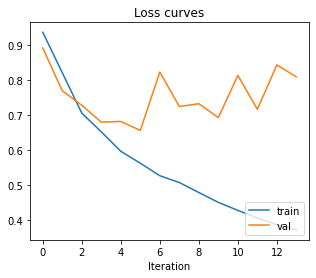

In [22]:
fig = plt.figure()
plt.title('Loss curves')
plt.plot(train_loss_history, '-', label='train')
plt.plot(val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
writer.add_figure(f"Loss curves", fig)
fig

## Testing the Model

As we trained a model and improved it on the validation set, we can now test it on the test set.

In [23]:
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], collate_fn=collate, drop_last=False)

_, test_acc, test_rmse, y_pred = validation_metrics(model, test_loader)
y_true = [x['label'].item() for x in test_dataset]
report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'], output_dict=True)
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

writer.add_hparams(params,{"macro_acc":test_acc, "mse": test_rmse, "f1-score": report['macro avg']['f1-score'],
                         "precision":report['macro avg']['precision'], "recall":report['macro avg']['recall']})
writer.close()

              precision    recall  f1-score   support

    negative       0.63      0.87      0.73       643
     neutral       0.72      0.45      0.56      1644
    positive       0.71      0.86      0.78      1811

    accuracy                           0.70      4098
   macro avg       0.69      0.73      0.69      4098
weighted avg       0.70      0.70      0.68      4098



## Inference

Now that we trained a sufficiently good sentiment classifier, let's run the below cell and type some text to see some predictions (type exit to quit the demo). Since we used a small data, don't expect too much :).

In [24]:
text = ''
w2i = vocab
while True:
    text = input()
    if text == 'exit':
        break
    
    words = torch.tensor([
        w2i.get(word, w2i['<unk>'])
        for word in nltk.word_tokenize(text)
    ]).long().to(device).view(-1, 1)  # T x B
    with torch.no_grad():
        pred = model(words).cpu()
        probs = F.softmax(pred, dim=1)
    prob, idx = torch.max(probs, dim=1)
    if idx == 0:
        txt = ':('
    elif idx == 1:
        txt = ':/'
    elif idx == 2:
        txt = ':)'
        
    print('Input text: {}\n'.format(text),
        'Sentiment -> {}, Confidence -> {:.3f}% '.format(txt, *prob*100))
    print()

Input text: awesome but expensive
 Sentiment -> :), Confidence -> 71.865% 

Input text: expensive but awesome
 Sentiment -> :/, Confidence -> 42.852% 

Input text: comfortable place polite staff
 Sentiment -> :/, Confidence -> 75.686% 

Input text: loved it rooms could have been cleaner but food was great
 Sentiment -> :), Confidence -> 84.820% 

Input text: loved it
 Sentiment -> :), Confidence -> 84.636% 

Input text: disgusting rooms, unbearable smell
 Sentiment -> :(, Confidence -> 86.970% 

Input text: totally worth the money, staff helpful, had a great time
 Sentiment -> :), Confidence -> 83.638% 

Input text: kids loved it, great place to rest
 Sentiment -> :), Confidence -> 81.685% 

